In [17]:
import sys
from pathlib import Path

# Add parent directory to path so we can import src module
sys.path.insert(0, str(Path.cwd().parent))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from scipy.sparse import hstack

# Import custom modules from src directory for better organization
from src.preprocessing import (
    load_data,
    missing_value_handling,
    labels_encoding,
    clean_text,
    preprocess_data,
    get_text_stats,
    data_split,
    get_class_distribution,
    get_sample_message
)

from src.modeling import (
    vectorize_text,
    train_baseline_model,
    train_logistic_regression,
    train_decision_tree,
    save_model,
    get_feature_importance
)

from src.evaluation import (
    evaluate_model,
    print_evaluation_report,
    plot_confusion_matrix,
    analyze_errors,
    print_error_analysis,
    plot_roc_curve,
    compare_models,
    save_metrics_to_csv
)

# Set random seed
np.random.seed(42)
# Setup paths
figures_path = Path('../results/figures')

In [8]:
# Load Data & Basic check

df = pd.read_csv('../data/processed/spam_with_features.csv')

print(f"Shape: {df.shape}")
print(f"Rows: {df.shape[0]:,}")
print(f"Columns: {df.shape[1]}")

print("\nColumn names:")
print(df.columns.tolist())

print("\nFirst few rows:")
print(df.head())

# Check data types
print("\nData types:")
print(df.dtypes)

Shape: (5572, 25)
Rows: 5,572
Columns: 25

Column names:
['label', 'message', 'message_length', 'word_count', 'avg_word_length', 'num_exclamation', 'num_question', 'num_capitals', 'capital_ratio', 'has_numbers', 'has_currency', 'has_phone', 'has_url', 'urgency_count', 'money_count', 'action_count', 'has_time_words', 'starts_with_free', 'congratulations', 'youve_won', 'click_here', 'call_now', 'txt_to', 'reply_to', 'label_numeric']

First few rows:
  label                                            message  message_length  \
0   ham  Go until jurong point, crazy.. Available only ...             111   
1   ham                      Ok lar... Joking wif u oni...              29   
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...             155   
3   ham  U dun say so early hor... U c already then say...              49   
4   ham  Nah I don't think he goes to usf, he lives aro...              61   

   word_count  avg_word_length  num_exclamation  num_question  num_capitals  \


In [10]:
# Data Prep & Preprocessing

# Check for missing values
missing = df.isnull().sum()
print("\nMissing values:")
print(missing[missing > 0])

if missing.sum() > 0:
    df = missing_value_handling(df)
    print("✓ Missing values handled")

# Ensure we have required columns
required_cols = ['label', 'message', 'cleaned_message', 'label_numeric']
missing_cols = [col for col in required_cols if col not in df.columns]

if missing_cols:
    print(f"\n⚠ Missing required columns: {missing_cols}")
    
    # Create cleaned_message if it doesn't exist
    if 'cleaned_message' not in df.columns:
        print("Creating cleaned_message column...")
        df = preprocess_data(df, text_col='message')
        print("✓ Text cleaned")
    
    # Create label_numeric if it doesn't exist
    if 'label_numeric' not in df.columns:
        print("Creating label_numeric column...")
        df['label_numeric'] = df['label'].map({'ham': 0, 'spam': 1})
        print("✓ Labels encoded")
else:
    print("✓ All required columns present")

# Verify class distribution
class_dist = df['label'].value_counts()
print("\nClass distribution:")
print(class_dist)
print(f"\nClass balance:")
for label, count in class_dist.items():
    pct = count / len(df) * 100
    print(f"  {label}: {count:,} ({pct:.1f}%)")


Missing values:
Series([], dtype: int64)

⚠ Missing required columns: ['cleaned_message']
Creating cleaned_message column...
✓ Text cleaned

Class distribution:
label
ham     4825
spam     747
Name: count, dtype: int64

Class balance:
  ham: 4,825 (86.6%)
  spam: 747 (13.4%)


In [12]:
# Feature Selection 

# Features from the list I'm considering based on EDA - 3 Tiers - must have, strong, and moderate
custom_features = [
    'has_phone',      
    'has_numbers',     
    'money_count',      
    'action_count',    
    'has_currency',    
    'message_length',   
    'has_url',          
    'word_count',       
]

print("\nCustom features selected (from EDA):")
for i, feat in enumerate(custom_features, 1):
    print(f"  {i}. {feat}")

# Verify all features exist
available_features = [f for f in custom_features if f in df.columns]
missing_features = [f for f in custom_features if f not in df.columns]

print(f"\n Available: {len(available_features)}/{len(custom_features)}")
if missing_features:
    print(f"Missing: {missing_features}")
    custom_features = available_features



Custom features selected (from EDA):
  1. has_phone
  2. has_numbers
  3. money_count
  4. action_count
  5. has_currency
  6. message_length
  7. has_url
  8. word_count

 Available: 8/8


In [14]:
# Train - Test Split

train_df, test_df = data_split(df, test_size=0.2, random_state=42)

print(f"\nTrain set: {len(train_df):,} samples")
print(f"Test set:  {len(test_df):,} samples")

# Verify stratification worked
print("\nTrain set class distribution:")
print(train_df['label'].value_counts(normalize=True) * 100)

print("\nTest set class distribution:")
print(test_df['label'].value_counts(normalize=True) * 100)

# Extract features and labels
X_train_text = train_df['cleaned_message']
X_test_text = test_df['cleaned_message']

y_train = train_df['label_numeric']
y_test = test_df['label_numeric']

# Extract custom features
X_train_custom = train_df[custom_features].values
X_test_custom = test_df[custom_features].values

print(f"\n✓ Data split complete")
print(f"Custom features shape: {X_train_custom.shape}")


Train set: 4,457 samples
Test set:  1,115 samples

Train set class distribution:
label
ham     86.60534
spam    13.39466
Name: proportion, dtype: float64

Test set class distribution:
label
ham     86.547085
spam    13.452915
Name: proportion, dtype: float64

✓ Data split complete
Custom features shape: (4457, 8)


In [15]:
# Text Vectorization

X_train_tfidf, X_test_tfidf, vectorizer = vectorize_text(
    X_train_text,
    X_test_text,
    vectorizer_type='tfidf',
    max_features=5000,
    ngram_range=(1, 1)  # unigrams only
)

print(f"\nTF-IDF vectorization complete:")
print(f"  Training shape: {X_train_tfidf.shape}")
print(f"  Test shape:     {X_test_tfidf.shape}")
print(f"  Vocabulary size: {len(vectorizer.get_feature_names_out())}")

# Save vectorizer for future use
save_model(vectorizer, '../models/tfidf_vectorizer.pkl')



TF-IDF vectorization complete:
  Training shape: (4457, 5000)
  Test shape:     (1115, 5000)
  Vocabulary size: 5000
Model saved to ../models/tfidf_vectorizer.pkl


In [19]:
# Combining TF-IDF features with custom features

# Convert custom features to float to ensure compatibility with sparse matrices
X_train_custom_float = X_train_custom.astype(float)
X_test_custom_float = X_test_custom.astype(float)

X_train_combined = hstack([X_train_tfidf, X_train_custom_float])
X_test_combined = hstack([X_test_tfidf, X_test_custom_float])

print(f"\nCombined feature matrix:")
print(f"  TF-IDF features: {X_train_tfidf.shape[1]}")
print(f"  Custom features: {X_train_custom_float.shape[1]}")
print(f"  Total features:  {X_train_combined.shape[1]}")
print(f"\nTraining shape: {X_train_combined.shape}")
print(f"Test shape:     {X_test_combined.shape}")


Combined feature matrix:
  TF-IDF features: 5000
  Custom features: 8
  Total features:  5008

Training shape: (4457, 5008)
Test shape:     (1115, 5008)



Evaluation Report: Baseline Model (Majority Class)

Accuracy:  0.8655
Precision: 0.0000
Recall:    0.0000
F1 Score:  0.0000

------------------------------------------------------------
Classification Report:
------------------------------------------------------------

              precision    recall  f1-score   support

         ham       0.87      1.00      0.93       965
        spam       0.00      0.00      0.00       150

    accuracy                           0.87      1115
   macro avg       0.43      0.50      0.46      1115
weighted avg       0.75      0.87      0.80      1115

Confusion matrix saved to ../results/figures/confusion_matrix_baseline.png


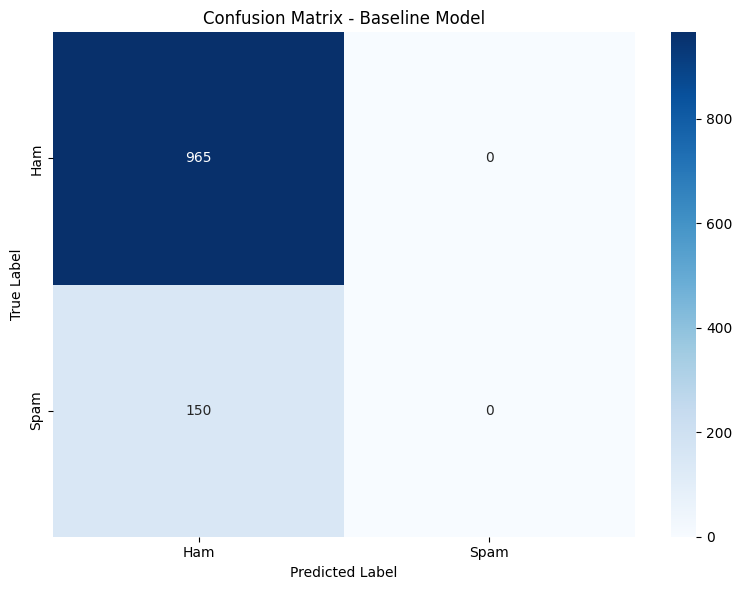


Baseline Interpretation:
The baseline always predicts 'ham' (majority class).
This gives high accuracy due to class imbalance,
but completely fails to detect any spam (recall = 0).
Any real model should significantly outperform this baseline.


In [23]:
# Baseline Model

baseline = train_baseline_model(X_train_combined, y_train)

# Predictions
y_pred_baseline = baseline.predict(X_test_combined)

# Evaluation
print_evaluation_report(y_test, y_pred_baseline, "Baseline Model (Majority Class)")

# Confusion matrix
fig, ax = plot_confusion_matrix(
    y_test,
    y_pred_baseline,
    "Baseline Model",
    save_path='../results/figures/confusion_matrix_baseline.png'
)
plt.show()

# Store metrics
baseline_metrics = evaluate_model(y_test, y_pred_baseline, "Baseline")


print("\nBaseline Interpretation:")
print("The baseline always predicts 'ham' (majority class).\nThis gives high accuracy due to class imbalance,\nbut completely fails to detect any spam (recall = 0).\nAny real model should significantly outperform this baseline.")
